In [2]:
import pandas as pd
import torch
from transformers import TextClassificationPipeline, AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer
model_name = "ElKulako/cryptobert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, max_length=64, truncation=True, padding='max_length')



C:\Users\andre.premstaller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read the Excel file
file_path = "data/stockwits/stockwits_crypto.xlsx"
df = pd.read_excel(file_path)

#change labels: "Bearish" : 0, "Neutral": 1, "Bullish": 2
def change_labels(label):
    if label == 0:
        return "Bearish"
    elif label == 1:
        return "Neutral"
    elif label == 2:
        return "Bullish"
    else:
        return None
    
df['label'] = df['label'].apply(change_labels)

In [ ]:
df

,text,label
0,"if you were curious, price chose the lowest ch...",Neutral
1,"true, not even 10k followers here yet.",Neutral
2,dogecoin co-founder billy markus hits back at ...,Neutral
3,"i’m curious, do any bulls have a price where ...",Neutral
4,friday everybody buy 10 more on friday,Bullish
...,...,...
599995,so did i 850% with ! get in below a dollar. st...,Bullish
599996,notice it’s the same few brain dead people bas...,Bullish
599997,attention!!! anyone under the age of 18…. stea...,Bullish
599998,dickhead bears fucked. keep your big mouths s...,Bullish


In [7]:

# Assuming your dataframe is named df
# First, let's count the number of unique labels
label_counts = df['label'].value_counts()

# Calculate the number of samples per label for equal distribution
num_samples_per_label = 15000 // len(label_counts)

# Sample the dataframe equally for each label
df_subsampled = df.groupby('label').apply(lambda x: x.sample(num_samples_per_label)).reset_index(drop=True)

# If there's any remaining rows to fill up to 10,000 (due to integer division), sample additional rows
remaining_rows = 15000 - len(df_subsampled)
if remaining_rows > 0:
    additional_rows = df.drop(df_subsampled.index).sample(remaining_rows)
    df_subsampled = pd.concat([df_subsampled, additional_rows])

print(df_subsampled['label'].value_counts())

label
Bearish    5000
Bullish    5000
Neutral    5000
Name: count, dtype: int64


C:\Users\andre.premstaller\AppData\Local\Temp\ipykernel_21564\3610144158.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_subsampled = df.groupby('label').apply(lambda x: x.sample(num_samples_per_label)).reset_index(drop=True)


<Axes: xlabel='label'>

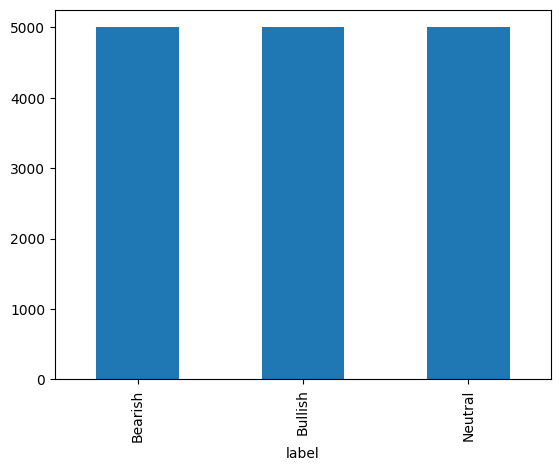

In [8]:
#plot distribution of labels
df_subsampled['label'].value_counts().plot(kind='bar')

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Assuming the dataframe has columns 'text' and 'label'
texts = df_subsampled['text'].astype(str).tolist()  # Ensure texts are strings
true_labels = df_subsampled['label'].tolist()

# Define a mapping from string labels to numeric labels
label_mapping = {"Bearish": 0, "Neutral": 1, "Bullish": 2}

# Inverse mapping from numeric labels to string labels
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Get predictions
predictions = pipe(texts)

Accuracy: 0.7685333333333333
Precision: 0.7641733068175386
Recall: 0.7685333333333333
F1-Score: 0.759236650152662


In [22]:
# Extract predicted labels
predicted_labels = [label_mapping[pred['label']] for pred in predictions]
#add predicted labels to the dataframe
df_subsampled['predicted_label'] = predicted_labels

# Map true labels to numeric
true_labels_numeric = [label_mapping[label] for label in true_labels]

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels_numeric, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels_numeric, predicted_labels, average='weighted')

# Display the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Calculate precision, recall, and F1-score for each individual class
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(true_labels_numeric, predicted_labels, average=None, labels=[0, 1, 2])

# Display the results for each class
for i, label in inv_label_mapping.items():
    print(f"{label} Precision: {precision_per_class[i]}")
    print(f"{label} Recall: {recall_per_class[i]}")
    print(f"{label} F1-Score: {f1_per_class[i]}")

Accuracy: 0.7685333333333333
Precision: 0.7641733068175386
Recall: 0.7685333333333333
F1-Score: 0.759236650152662
Bearish Precision: 0.865117098080648
Bearish Recall: 0.9826
Bearish F1-Score: 0.9201236070793145
Neutral Precision: 0.732643615573101
Neutral Recall: 0.5382
Neutral F1-Score: 0.6205465236942235
Bullish Precision: 0.6947592067988668
Bullish Recall: 0.7848
Bullish F1-Score: 0.7370398196844478


# Sentiment Analysis Evaluation

This documentation provides an overview of the code used for evaluating the performance of a sentiment analysis model that predicts three classes: "Bullish", "Bearish", and "Neutral". It also explains the evaluation metrics and their results.

## Code Description

The code performs the following steps:

1. **Load and Prepare Data**:
   - Assumes a dataframe `df_subsampled` with columns `text` (containing the text data) and `label` (containing the true sentiment labels).

2. **Text and Label Preparation**:
   - Converts the text data to a list of strings.
   - Converts the true sentiment labels to a list.

3. **Label Mapping**:
   - Defines a mapping from string labels to numeric labels for processing.
   - Creates an inverse mapping to convert numeric predictions back to string labels.

4. **Model Predictions**:
   - Uses a pipeline `pipe` to generate predictions for the text data.
   - Extracts the predicted labels and maps them to numeric labels.

5. **Metric Calculation**:
   - Calculates accuracy, precision, recall, and F1-score using `accuracy_score` and `precision_recall_fscore_support` from `sklearn.metrics`.
   - Computes precision, recall, and F1-score for each sentiment class individually.

6. **Result Display**:
   - Prints the overall accuracy, precision, recall, and F1-score.
   - Prints precision, recall, and F1-score for each sentiment class (Bullish, Bearish, Neutral).

## Results

The performance of the sentiment analysis model is summarized below:

- **Overall Metrics**:
  - **Accuracy**: 0.7685
    - The model correctly predicts the sentiment about 76.85% of the time.
  - **Precision**: 0.7642
    - On average, 76.42% of the positive predictions are correct.
  - **Recall**: 0.7685
    - The model correctly identifies 76.85% of all actual sentiments.
  - **F1-Score**: 0.7592
    - The balance between precision and recall is approximately 75.92%.

- **Class-wise Metrics**:
  - **Bearish Sentiment**:
    - **Precision**: 0.8651
    - **Recall**: 0.9826
    - **F1-Score**: 0.9201
  - **Neutral Sentiment**:
    - **Precision**: 0.7326
    - **Recall**: 0.5382
    - **F1-Score**: 0.6205
  - **Bullish Sentiment**:
    - **Precision**: 0.6948
    - **Recall**: 0.7848
    - **F1-Score**: 0.7370

### Interpretation

- **Overall Performance**:
  - The model's accuracy of 76.85% indicates a generally reliable performance in predicting the correct sentiment class out of bullish, bearish, and neutral.
  - The precision, recall, and F1-score values are close to the accuracy, suggesting a balanced performance across different types of errors (false positives and false negatives).

- **Bearish Sentiment**:
  - **High Precision (0.8651)**: The model is highly accurate when it predicts a sentiment as bearish. Most of the predicted bearish sentiments are correct.
  - **Very High Recall (0.9826)**: The model successfully identifies almost all actual bearish instances. It rarely misses a bearish sentiment.
  - **High F1-Score (0.9201)**: The model excels in predicting bearish sentiments, combining high precision and recall. This indicates strong performance in scenarios where accurately identifying bearish sentiments is crucial, such as risk management in financial markets.

- **Neutral Sentiment**:
  - **Moderate Precision (0.7326)**: When the model predicts a sentiment as neutral, it is correct 73.26% of the time. This indicates some room for improvement in reducing false positives for neutral predictions.
  - **Lower Recall (0.5382)**: The model captures only 53.82% of actual neutral instances, meaning it often misses neutral sentiments. This could be due to the nuanced nature of neutral sentiment, which may be harder to distinguish.
  - **Moderate F1-Score (0.6205)**: The F1-score reflects the balance of moderate precision and lower recall. Improving the recall for neutral predictions is essential to ensure a comprehensive understanding of sentiments, particularly in applications like public opinion analysis.

- **Bullish Sentiment**:
  - **Good Precision (0.6948)**: The model correctly identifies bullish sentiments nearly 69.48% of the time, indicating a good but improvable performance in reducing false positives.
  - **High Recall (0.7848)**: The model successfully identifies 78.48% of actual bullish instances, capturing most of the positive sentiments.
  - **Balanced F1-Score (0.7370)**: The model has a relatively balanced performance for bullish predictions. Enhancing precision can help in applications like marketing, where accurately identifying positive feedback is vital.

# Implementation of Cryptobert on other Datasets

In [28]:
finance_crypto = pd.read_csv("data/finance_stocks/finance_stocks-train-cleaned.csv")

## This dataset also takes Tweets from Twitter, for various crypto coins and is cleaned/ready for prediction.

In [29]:
#general info about the dataset
finance_crypto.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22383 entries, 0 to 22382
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   timestamp          14363 non-null  object
 1   tweet_text         20899 non-null  object
 2   tweet_url          22383 non-null  object
 3   tweet_type         22383 non-null  object
 4   price_of_ticker    22383 non-null  object
 5   change_of_ticker   22383 non-null  object
 6   tickers_mentioned  22383 non-null  object
 7   category           22383 non-null  object
 8   clean_tweet_text   20895 non-null  object
 9   Tweet_lemmatized   22383 non-null  object
 10  stemmed_text       20895 non-null  object
dtypes: object(11)
memory usage: 1.9+ MB


In [ ]:
#Load the model and tokenizer
model_name = "ElKulako/cryptobert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, max_length=64, truncation=True, padding='max_length')



In [30]:
#take a subset to reduce the computing demand
finance_crypto = finance_crypto.sample(10000)

texts = finance_crypto['clean_tweet_text'].astype(str).tolist()  # Ensure texts are strings

# Get predictions
predictions_fin = pipe(texts)



In [31]:
predictions_fin

[{'label': 'Neutral', 'score': 0.49850910902023315},
 {'label': 'Neutral', 'score': 0.523958683013916},
 {'label': 'Neutral', 'score': 0.6334937810897827},
 {'label': 'Bearish', 'score': 0.8992781043052673},
 {'label': 'Neutral', 'score': 0.5511392951011658},
 {'label': 'Neutral', 'score': 0.5189232230186462},
 {'label': 'Neutral', 'score': 0.5283640027046204},
 {'label': 'Neutral', 'score': 0.7396314144134521},
 {'label': 'Neutral', 'score': 0.6292374134063721},
 {'label': 'Bullish', 'score': 0.4489898383617401},
 {'label': 'Neutral', 'score': 0.5506784319877625},
 {'label': 'Neutral', 'score': 0.7788625955581665},
 {'label': 'Neutral', 'score': 0.8612721562385559},
 {'label': 'Neutral', 'score': 0.5780410766601562},
 {'label': 'Neutral', 'score': 0.46375149488449097},
 {'label': 'Neutral', 'score': 0.7470678091049194},
 {'label': 'Neutral', 'score': 0.8897602558135986},
 {'label': 'Bullish', 'score': 0.4489898383617401},
 {'label': 'Bullish', 'score': 0.5936468839645386},
 {'label': 

In [32]:
# Extract predicted labels
predicted_labels_fin = [label_mapping[pred['label']] for pred in predictions_fin]

#add predicted labels to the dataframe
finance_crypto['predicted_label'] = predicted_labels_fin


<Axes: xlabel='predicted_label'>

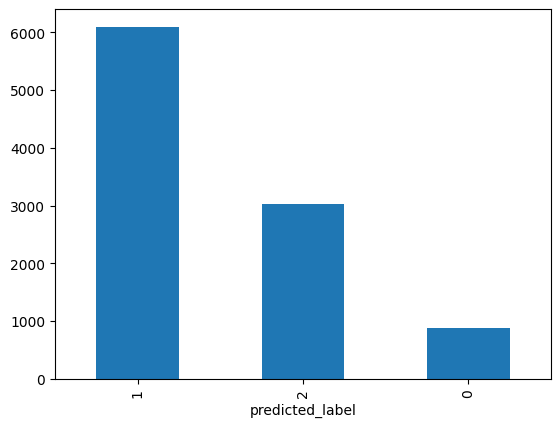

In [34]:
#compare predicted_lavel of finance_crypto with predicted_label of stockwits
finance_crypto['predicted_label'].value_counts().plot(kind='bar')
#df_subsampled['predicted_label'].value_counts().plot(kind='bar')
